# RFM (Recency Frequency Monetary) Analysis


RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries

RFM stands for the three dimensions:

1.Recency – How recently did the customer purchase?

2.Frequency – How often do they purchase?

3.Monetary Value – How much do they spend?

In [1]:
#importing all the packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading data into pandas dataframe
df = pd.read_csv("rfm_data.csv")
df.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


In [3]:
#information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


In [4]:
df.describe()

,CustomerID,TransactionAmount,OrderID
count,1000.000000,1000.00000,1000.000000
mean,5554.789000,513.67781,554071.398000
std,2605.014863,286.09870,264695.448814
min,1011.000000,12.13000,100096.000000
25%,3273.000000,257.12000,313152.000000
50%,5538.000000,523.56500,564671.500000
75%,7821.750000,759.86000,783052.250000
max,9991.000000,999.44000,999695.000000


In [5]:
#checking for null values
df.isnull().sum()

CustomerID            0
PurchaseDate          0
TransactionAmount     0
ProductInformation    0
OrderID               0
Location              0
dtype: int64

In [6]:
#last date available in our dataset
df['PurchaseDate'].max()

'2023-06-10'

In [9]:
#use latest date in our data as current date.
import datetime as dt
now = dt.date(2023,8,9)

In [10]:
df['date'] = pd.DatetimeIndex(df.PurchaseDate).date

In [11]:
#grouping the customerID last date they purchased
recency_factor = df.groupby('CustomerID')['date'].max().reset_index()
recency_factor.columns = ['CustomerID','LastPurchaseDate']
recency_factor.head()

,CustomerID,LastPurchaseDate
0,1011,2023-05-08
1,1025,2023-05-20
2,1029,2023-06-10
3,1046,2023-04-28
4,1049,2023-05-28


In [12]:
#calculate how often he is purchasing with reference to latest date in days..

recency_factor['Recency'] = recency_factor.LastPurchaseDate.apply(lambda x : (now - x).days)

In [13]:
recency_factor.head()

,CustomerID,LastPurchaseDate,Recency
0,1011,2023-05-08,93
1,1025,2023-05-20,81
2,1029,2023-06-10,60
3,1046,2023-04-28,103
4,1049,2023-05-28,73


In [14]:
recency_factor.drop('LastPurchaseDate',inplace=True,axis=1)
recency_factor.head()

,CustomerID,Recency
0,1011,93
1,1025,81
2,1029,60
3,1046,103
4,1049,73


In [15]:
#calculating frequency 
frequency_data = df.groupby('CustomerID')['OrderID'].count().reset_index()
frequency_data.rename(columns={'OrderID': 'Frequency'}, inplace=True)
frequency_data.head()

,CustomerID,Frequency
0,1011,2
1,1025,1
2,1029,1
3,1046,1
4,1049,1


In [16]:
#calculating monetary value
monetary_data = df.groupby('CustomerID')['TransactionAmount'].sum().reset_index()
monetary_data.rename(columns = {'TransactionAmount':'MonetaryValue'},inplace = True)
monetary_data.head()

,CustomerID,MonetaryValue
0,1011,1129.02
1,1025,359.29
2,1029,704.99
3,1046,859.82
4,1049,225.72


In [17]:
#Combine all together all dataframe in so we have recency, frequency and monetary values together
#combining recency and frequency
rf = recency_factor.merge(frequency_data,on = 'CustomerID')
rfm = rf.merge(monetary_data,on= 'CustomerID')
rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
1011,93,2,1129.02
1025,81,1,359.29
1029,60,1,704.99
1046,103,1,859.82
1049,73,1,225.72


In [18]:
#checking correctness output
df[df['CustomerID']==1025]

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,date
659,1025,2023-05-20,359.29,Product D,296412,New York,2023-05-20


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm)

Text(0.5, 1.0, 'Elbow Curve')

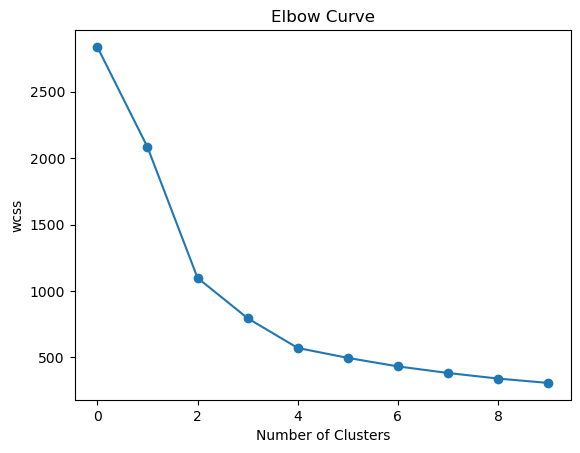

In [20]:
from sklearn.cluster import KMeans
inertia = []
for i in np.arange(1,11):
    k_means = KMeans(n_clusters=i)
    k_means.fit(scaled)
    inertia.append(k_means.inertia_)
plt.plot(inertia,marker = 'o')   
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.title('Elbow Curve')

In [21]:
kmeans = KMeans(n_clusters=3).fit(scaled)

In [22]:
# this creates a new column called cluster which has cluster number for each row respectively.
rfm['cluster'] = kmeans.labels_

In [23]:
rfm.head()

,Recency,Frequency,MonetaryValue,cluster
CustomerID,,,,
1011,93,2,1129.02,1
1025,81,1,359.29,2
1029,60,1,704.99,2
1046,103,1,859.82,0
1049,73,1,225.72,2


<AxesSubplot:xlabel='cluster', ylabel='Recency'>

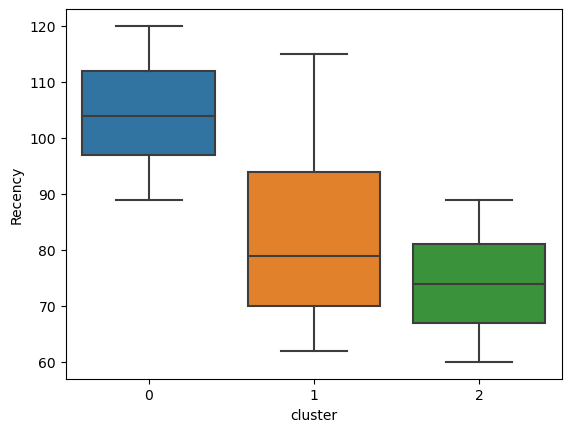

In [24]:
'''
cluster 1 have high recency rate which is bad. cluster 0 and cluster 2 having low so they are in race of platinum
and gold customer.
'''

sns.boxplot(rfm.cluster,rfm.Recency)

<AxesSubplot:xlabel='cluster', ylabel='Frequency'>

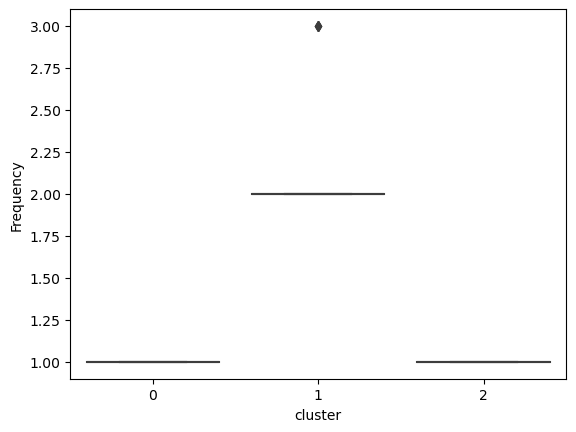

In [25]:
'''
cluster 0 and cluster 1 have low frequency rate which is bad. cluster 2 having high so they are in 
race of platinum.
'''
sns.boxplot(rfm.cluster,rfm.Frequency)

<AxesSubplot:xlabel='cluster', ylabel='MonetaryValue'>

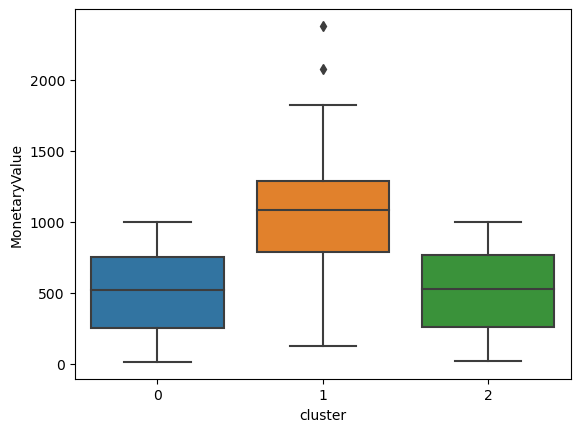

In [26]:
'''
cluster 1 have low Monetary rate which is bad. cluster 2 have highest Montary (money spend) platinum where as 
cluster 0 have medium level(Gold) and cluster 0 is silver customer.
'''
sns.boxplot(rfm.cluster,rfm.MonetaryValue)

In [27]:
group = rfm.groupby('cluster')['Recency','Frequency','MonetaryValue'].mean()
group

,Recency,Frequency,MonetaryValue
cluster,,,
0,104.439834,1.000000,508.217033
1,82.686275,2.058824,1072.476078
2,74.012107,1.000000,518.210460



we need to set objective and outcome of analysis, for this example goal is to define class of customer example - Platinum, Gold and Silver.

1.Platinum customer - frequent and more revenue generator.

2.Gold customer - frequent but less revenue generator.

3.silver customer - less frequent and less revenue generator.

# Based on customer Segmentation we found out cluster
2 is Platinum customers Cluster 

1 is Gold Customers Cluster

0 is Silver Customers

In [28]:
def func(row):
    if row['cluster']==0:
        return "Silver"
    elif row['cluster']==1:
        return "Gold"
    else:
        return "Platinum"

In [29]:
rfm['segmentation'] = rfm.apply(func,axis=1)

In [30]:
rfm.head()

,Recency,Frequency,MonetaryValue,cluster,segmentation
CustomerID,,,,,
1011,93,2,1129.02,1,Gold
1025,81,1,359.29,2,Platinum
1029,60,1,704.99,2,Platinum
1046,103,1,859.82,0,Silver
1049,73,1,225.72,2,Platinum


In [31]:
rfm['segmentation'].value_counts()

Silver      482
Platinum    413
Gold         51
Name: segmentation, dtype: int64

# Summary 
In our dataset there are 413 platinum members that is good and 51 gold members 482 silver members as we can see 
there are more silver members in our data we need to concentrate  on these silver members  by providing discounts or 
engaging offers in order to convert them into gold or platinum members